Domain 1 integral:  24.731400778642364  std:  8.611470615939208 exp:  24.156146041267508
Domain 2 integral:  23.61772184723606  std:  8.43830525205324 exp:  23.446417904377995
Domain whole integral:  39.506781791738305  std:  12.816205319394166 exp:  40.59191793818661
=========================== mis ============================
Domain 1 estimated value:  24.17897924744805  std:  1.7082149993835132
Domain 2 estimated value:  23.34769690986753  std:  1.7498138660357814
40.68551093622926 std 2.6939504379100883  (Expected 40.59192)
=========================== naive ============================
Domain 1 estimated value:  24.10522758859885  std:  1.6960526432276857
Domain 2 estimated value:  23.46135550335249  std:  1.6960526432276857
40.58626866612446 std 2.7560740185755406  (Expected 40.59192)


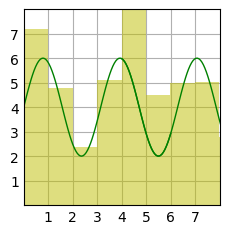

In [1]:
import matplotlib.pyplot as plt
import numpy as np

class RIS:
    y = 0
    w_sum = 0
    M = 0
    W = 0
    def __init__(self) -> None:
        pass
    def update(self, x, w):
        """ update the reservoir
        @param: selected x
        @param: weight (hat_pdf(x) / pdf(x))
        """
        self.w_sum = self.w_sum + w
        self.M = self.M + 1
        r = np.random.uniform(0, 1)
        if r < (w / self.w_sum): 
            self.y = x

plt.style.use('_mpl-gallery')

def is_in_domain(domain, sample):
        return sample <= domain[-1] and sample >= domain[0]

def integrand(x):
    # the integrand may not always equal to target_pdf
    return (4 + 2 * np.sin(2 * x))
    
def target_pdf(x):
    return integrand(x)


"""
Version2: different source pdf for the different part of the same domain
"""
fig1, ax1 = plt.subplots()
first_domain = np.linspace(0, 6, 100)
second_domain = np.linspace(4, 10, 100)
ax1.plot(first_domain, target_pdf(first_domain), 'g', linewidth=1)
ax1.plot(second_domain, target_pdf(second_domain), 'g', linewidth=1)

def first_source_pdf(x):
    if x >= 0 and x < 6:
        return 1 / 6.0
    return 0

def second_source_pdf(x):
    if x >= 4 and x < 10:
        return 1 / 6.0
    return 0

pdf1 = np.zeros(len(first_domain))
pdf2 = np.zeros(len(second_domain))
for i in range (0, len(first_domain)):
    pdf1[i] = first_source_pdf(first_domain[i])
for i in range (0, len(second_domain)):
    pdf2[i] = first_source_pdf(second_domain[i])
# ax1.plot(first_domain, pdf1, 'r', linewidth=1)
# ax1.plot(second_domain, pdf2, 'y', linewidth=1)


#***********************************
#* Regular Monte Carlo integration
#***********************************
sample_size = 1000

value = 0
contributions = []
for i in range(0,sample_size):
    y = np.random.uniform(0, 6.0)
    pdf = 1.0 / 6.0
    c = integrand(y) / pdf
    value += c
    contributions.append(c)
print("Domain 1 integral: ", value / sample_size, " std: ", np.std(contributions), "exp: ", 25 - np.cos(12))

value = 0
for i in range(0,sample_size):
    y = np.random.uniform(4, 10)
    pdf = 1.0 / 6.0
    c = integrand(y) / pdf
    value += c
    contributions.append(c)
print("Domain 2 integral: ", value / sample_size, " std: ", np.std(contributions), "exp: ", 24 - np.cos(20) + np.cos(8))

value = 0
for i in range(0,sample_size):
    y = np.random.uniform(0, 10)
    pdf = 1.0 / 10.0
    c = integrand(y) / pdf
    value += c
    contributions.append(c)
print("Domain whole integral: ", value / sample_size, " std: ", np.std(contributions), "exp: ", 41 - np.cos(20))

ys_naive = np.zeros(sample_size)
ws_naive = np.zeros(sample_size)
ys_mis = np.zeros(sample_size)
ws_mis = np.zeros(sample_size)
ys_bias = np.zeros(sample_size)
ws_bias = np.zeros(sample_size)

ws1 = np.zeros(sample_size)
ys1 = np.zeros(sample_size)
ws2 = np.zeros(sample_size)
ys2 = np.zeros(sample_size)

M = 32
#***********************************
#* MIS
#***********************************
value_mis = 0
value1_mis = 0
value2_mis = 0
contribute1_mis = []
contribute2_mis = []
contribute_mis = []

for idx in range(0, sample_size):
    reservoir1 = RIS()
    for i in range(0, M):
        x = np.random.uniform(0, 6) # uniform distributed
        w = target_pdf(x) / first_source_pdf(x)
        reservoir1.update(x, w)
    reservoir1.W = 1 / target_pdf(reservoir1.y) * (1 / reservoir1.M) * reservoir1.w_sum
    ws1[idx] = reservoir1.W 
    ys1[idx] = reservoir1.y 
    value1_mis += integrand(reservoir1.y) * ws1[idx]
    contribute1_mis.append(ys1[idx])

    reservoir2 = RIS()
    for i in range(0, M):
        x = np.random.uniform(4, 10) # uniform distributed
        w = target_pdf(x) / second_source_pdf(x)
        reservoir2.update(x, w)
    reservoir2.W = 1 / target_pdf(reservoir2.y) * (1 / reservoir2.M) * reservoir2.w_sum
    ws2[idx] = reservoir2.W 
    ys2[idx] = reservoir2.y 
    value2_mis += integrand(reservoir2.y) * ws2[idx]
    contribute2_mis.append(ys2[idx])


    # talbot mis
    # reservoirs = [reservoir1, reservoir2]
    # reservoir = RIS()
    # for i in range (0, len(reservoirs)):
    #     r = reservoirs[i]
    #     p_sum = 0
    #     for j in range (0, len(reservoirs)):
    #         p_sum += target_pdf(r.y)
    #     m = target_pdf(r.y) / p_sum * len(reservoirs)
    #     # print("m", m)
    #     reservoir.update(r.y, target_pdf(r.y) * r.M * r.W * m)
    # reservoir.M = 0
    # for i in range (0, len(reservoirs)):
    #     if i == 0 and is_in_domain(first_domain, reservoir.y):
    #         reservoir.M +=  reservoirs[0].M 
    #     if i == 1 and is_in_domain(second_domain, reservoir.y):
    #         reservoir.M +=  reservoirs[1].M 
    # # print("M", reservoir.M)
    
    # ys_mis[idx] = reservoir.y 
    # ws_mis[idx] = 1 / target_pdf(reservoir.y) * (1 / reservoir.M) * reservoir.w_sum
    # value_mis += integrand(reservoir.y) * ws_mis[idx]
    # contribute_mis.append(ys_mis[idx])

    # restir mis
    reservoirs = [reservoir1, reservoir2]
    reservoir = RIS()
    for i in range (0, len(reservoirs)):
        r = reservoirs[i]
        reservoir.update(r.y, target_pdf(r.y) * r.W)
    reservoir.M = 0
    for i in range (0, len(reservoirs)):
        reservoir.M +=  reservoirs[i].M 
    p_sum = 0
    for i in range (0, len(reservoirs)):
        if i == 0 and is_in_domain(first_domain, reservoir.y):
            p_sum += target_pdf(reservoir.y) 
        if i == 1 and is_in_domain(second_domain, reservoir.y):
            p_sum += target_pdf(reservoir.y) 
    m = target_pdf(reservoir.y) / p_sum 
    ys_mis[idx] = reservoir.y 
    ws_mis[idx] = 1 / target_pdf(reservoir.y) * m * reservoir.w_sum
    value_mis += integrand(reservoir.y) * ws_mis[idx]
    contribute_mis.append(ys_mis[idx])



counts,bins = np.histogram(ys_mis, bins=512, density=True)
# plt.hist(bins[:-1], weights=counts, alpha=0.5, color="r")
print("=========================== mis ============================")
print("Domain 1 estimated value: ", value1_mis/sample_size, " std: ", np.std(contribute1_mis))
print("Domain 2 estimated value: ", value2_mis/sample_size, " std: ", np.std(contribute2_mis))
print(value_mis/sample_size, "std", np.std(contribute_mis), " (Expected 40.59192)")

#***********************************
#* BIAS
#***********************************
for idx in range(0, sample_size):
    reservoir1 = RIS()
    for i in range(0, M):
        x = np.random.uniform(0, 6) # uniform distributed
        w = target_pdf(x) / first_source_pdf(x)
        reservoir1.update(x, w)
    reservoir1.W = 1 / target_pdf(reservoir1.y) * (1 / reservoir1.M) * reservoir1.w_sum
    ws1[idx] = reservoir1.W 
    ys1[idx] = reservoir1.y 

    reservoir2 = RIS()
    for i in range(0, M):
        x = np.random.uniform(4, 10) # uniform distributed
        w = target_pdf(x) / second_source_pdf(x)
        reservoir2.update(x, w)
    reservoir2.W = 1 / target_pdf(reservoir2.y) * (1 / reservoir2.M) * reservoir2.w_sum
    ws2[idx] = reservoir2.W 
    ys2[idx] = reservoir2.y 

    reservoirs = [reservoir1, reservoir2]
    reservoir = RIS()
    for i in range (0, len(reservoirs)):
        r = reservoirs[i]
        p_sum = 0
        for j in range (0, len(reservoirs)):
            p_sum += target_pdf(r.y)
        m = target_pdf(r.y) / p_sum * len(reservoirs)
        reservoir.update(r.y, target_pdf(r.y) * r.M * r.W * m)
    reservoir.M = 0
    for i in range (0, len(reservoirs)):
        reservoir.M +=  reservoirs[i].M 
    ys_mis[idx] = reservoir.y 
    ws_mis[idx] = 1 / target_pdf(reservoir.y) * (1 / reservoir.M) * reservoir.w_sum


#***********************************
#* NAIVE
#***********************************
value = 0
value1 = 0
value2 = 0
contribute_naive = []
contribute1 = []
contribute2 = []


for idx in range(0, sample_size):
    reservoir1 = RIS()
    for i in range(0, M):
        x = np.random.uniform(0, 6) # uniform distributed
        w = target_pdf(x) / first_source_pdf(x)
        reservoir1.update(x, w)
    reservoir1.W = 1 / target_pdf(reservoir1.y) * (1.0 / M) * reservoir1.w_sum
    ws1[idx] = reservoir1.W 
    ys1[idx] = reservoir1.y 
    
    value1 += integrand(reservoir1.y) * ws1[idx]
    contribute1.append(reservoir1.y)



    reservoir2 = RIS()
    for i in range(0, M):
        x = np.random.uniform(4, 10) # uniform distributed
        w = target_pdf(x) / second_source_pdf(x)
        reservoir2.update(x, w)
    reservoir2.W = 1 / target_pdf(reservoir2.y) * (1 / reservoir2.M) * reservoir2.w_sum
    ws2[idx] = reservoir2.W 
    ys2[idx] = reservoir2.y 

    value2 += integrand(reservoir2.y) * ws2[idx]
    contribute2.append(reservoir1.y)


    reservoirs = [reservoir1, reservoir2]
    reservoir = RIS()
    for i in range (0, len(reservoirs)):
        r = reservoirs[i]
        reservoir.update(r.y, target_pdf(r.y) * r.M * r.W)
 
    
    pq1 = target_pdf(reservoir.y)
    pq2 = target_pdf(reservoir.y)

    
    Z = 0
    if pq1 > 0 and is_in_domain(first_domain, reservoir.y):
        Z += reservoir1.M
    if pq2 > 0 and is_in_domain(second_domain, reservoir.y):
        Z += reservoir2.M 

    ys_naive[idx] = reservoir.y
    ws_naive[idx] = 1 / target_pdf(reservoir.y) * (1 / Z) * reservoir.w_sum

    value += integrand(reservoir.y) * ws_naive[idx]
    contribute_naive.append(reservoir.y)


# ax1.scatter(ys_naive, 1 / ws_naive, s = 0.5, c = 'y')
counts,bins = np.histogram(ys_naive, bins=512, density=True)
plt.hist(bins[:-1], weights=counts, alpha=0.5, color="y")
print("=========================== naive ============================")
print("Domain 1 estimated value: ", value1/sample_size, " std: ", np.std(contribute1))
print("Domain 2 estimated value: ", value2/sample_size, " std: ", np.std(contribute2))
print(value/sample_size, "std", np.std(contribute_naive), " (Expected 40.59192)")


# ax1.scatter(ys1, 1 / ws1, s = 0.5)
# ax1.scatter(ys2, 1 / ws2, s = 0.5)


ax1.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))


plt.show()
